# Introduction

In this notebook, I will be condensing the stable diffusion script from the previous notebook into a function. This will make it easier to explore and add other features of the stable diffusion algorithm.

In [ ]:
# !pip install -Uq fastcore diffusers transformers

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

# torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
from diffusers import LMSDiscreteScheduler

In [7]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [8]:
prompts = ["a photograph of an astronaut riding a horse",
          "a painting of a kitten on the moon"]

height, width = 512, 512

In [9]:
from tqdm.auto import tqdm

In [10]:
def text_enc(prompts, maxlen=None):
  if maxlen==None:
    maxlen=tokenizer.model_max_length

  toks = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
  return text_encoder(toks.input_ids.to("cuda"))[0].half()

In [11]:
def mk_samples(prompts, g=7.5, steps=70):
  bs = len(prompts)
  text = text_enc(prompts)
  uncond = text_enc([""]*bs, maxlen=text.shape[1])
  emb = torch.concat([text,uncond])
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()
  scheduler.set_timesteps(steps)
  latents = latents * scheduler.init_noise_sigma

  for i, ts in enumerate(tqdm(scheduler.timesteps)):
    inp = torch.concat([latents]*2)
    inp = scheduler.scale_model_input(inp,ts)

    with torch.no_grad():
      t,u = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

    pred = u + g*(t - u)

    latents = scheduler.step(pred, ts, latents).prev_sample

  with torch.no_grad():
    return vae.decode(1/0.18215 * latents).sample


In [24]:
def mk_img(image):
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(1, 2, 0).numpy()
  return Image.fromarray((image * 255).round().astype("uint8"))

In [25]:
imgs = mk_samples(prompts=prompts)

/tmp/ipython-input-3733500010.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()


  0%|          | 0/70 [00:00<?, ?it/s]

In [14]:
from IPython.display import display

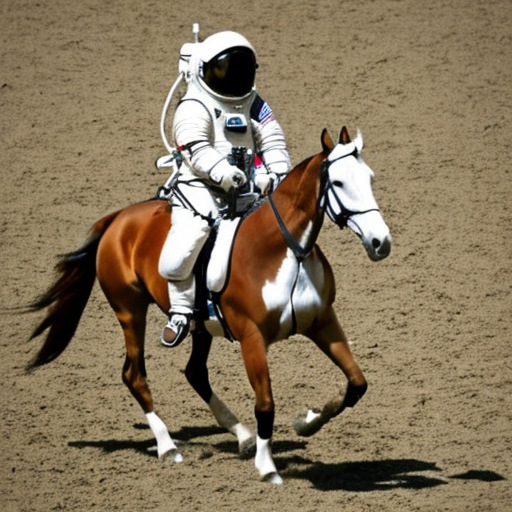

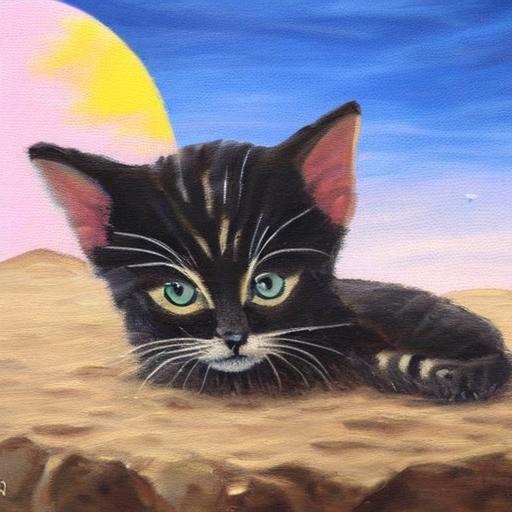

In [26]:
for img in imgs:
  display(mk_img(img))

# Negative Prompts

In [27]:
def neg_prompt(prompts, negative, g=7.5, steps=70):
  bs = len(prompts)
  text = text_enc(prompts)
  neg = text_enc(negative, maxlen=text.shape[1])
  emb = torch.concat([text,neg])
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()
  scheduler.set_timesteps(steps)
  latents = latents * scheduler.init_noise_sigma

  for i, ts in enumerate(tqdm(scheduler.timesteps)):
    inp = torch.cat([latents]*2)
    inp = scheduler.scale_model_input(inp,ts)

    with torch.no_grad():
      t,n = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

    pred = n + g*(t - n)

    latents = scheduler.step(pred, ts, latents).prev_sample

  with torch.no_grad():
    return vae.decode(1/0.18215 * latents).sample

In [28]:
torch.manual_seed(1000)
prompt = ["Labrador in the style of Vermeer"]
og = mk_samples(prompt)

/tmp/ipython-input-3733500010.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()


  0%|          | 0/70 [00:00<?, ?it/s]

In [30]:
def mk_img(image):
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image[0].detach().cpu().permute(1, 2, 0).numpy()
  return Image.fromarray((image * 255).round().astype("uint8"))

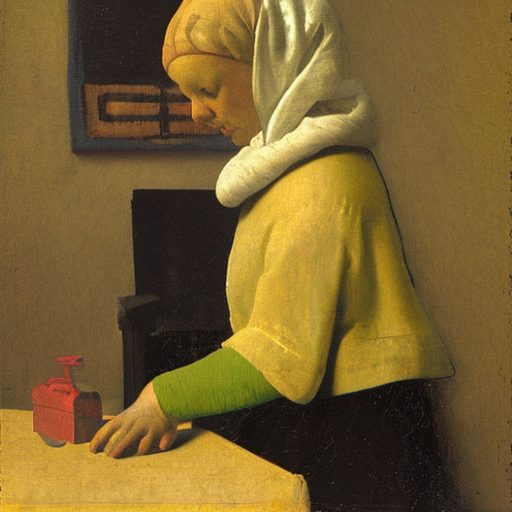

In [31]:
display(mk_img(og))

In [34]:
torch.manual_seed(1000)
negative = ['red']
np = neg_prompt(prompts=prompt, negative=negative)

/tmp/ipython-input-47190809.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()


  0%|          | 0/70 [00:00<?, ?it/s]

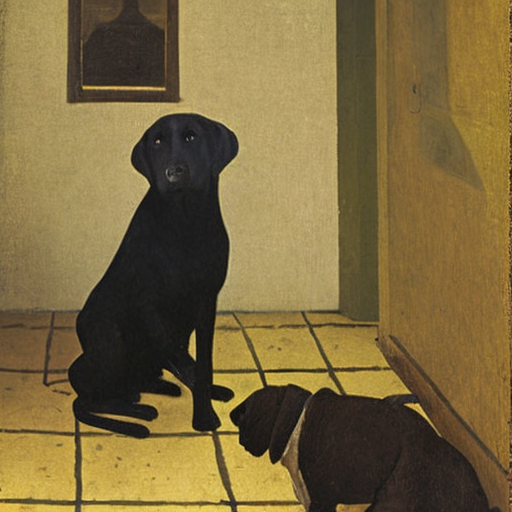

In [35]:
display(mk_img(np))

# Classifier-Free Guidance

In [36]:
import copy

In [37]:
def cfg(prompts, g, steps=70):
  bs = len(prompts)
  text = text_enc(prompts)
  uncond = text_enc([""]*bs, maxlen=text.shape[1])
  emb = torch.concat([text,uncond])

  results=[]

  for gs in g:
    current_scheduler = copy.deepcopy(scheduler)
    current_scheduler.set_timesteps(steps)
    latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()
    latents = latents * current_scheduler.init_noise_sigma

    for i, ts in enumerate(tqdm(current_scheduler.timesteps, desc=f"Guidance {gs}")):
      inp = torch.concat([latents]*2)
      inp = current_scheduler.scale_model_input(inp,ts)

      with torch.no_grad():
        t,u = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

      pred = u + gs*(t - u)

      latents = current_scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad():
      results.append(vae.decode(1/0.18215 * latents).sample)

  return results

In [38]:
def disp_imgs(images):
  plt.figure(figsize=(20,30))

  for i, img in enumerate(images):
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img[0].detach().cpu().permute(1, 2, 0).numpy().astype("float32")

    plt.subplot(1, len(images), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"gs = {guidance[i]}")

  plt.tight_layout()
  plt.show()

In [39]:
prompt = ["a photograph of an astronaut riding a horse"]

height, width = 512, 512

guidance = [1.1, 3, 7.5, 14]

In [40]:
imgs = cfg(prompts=prompt, g=guidance)

/tmp/ipython-input-1955174420.py:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = (torch.randn(bs, unet.in_channels, height//8, width//8)).to("cuda").half()


Guidance 1.1:   0%|          | 0/70 [00:00<?, ?it/s]

Guidance 3:   0%|          | 0/70 [00:00<?, ?it/s]

Guidance 7.5:   0%|          | 0/70 [00:00<?, ?it/s]

Guidance 14:   0%|          | 0/70 [00:00<?, ?it/s]

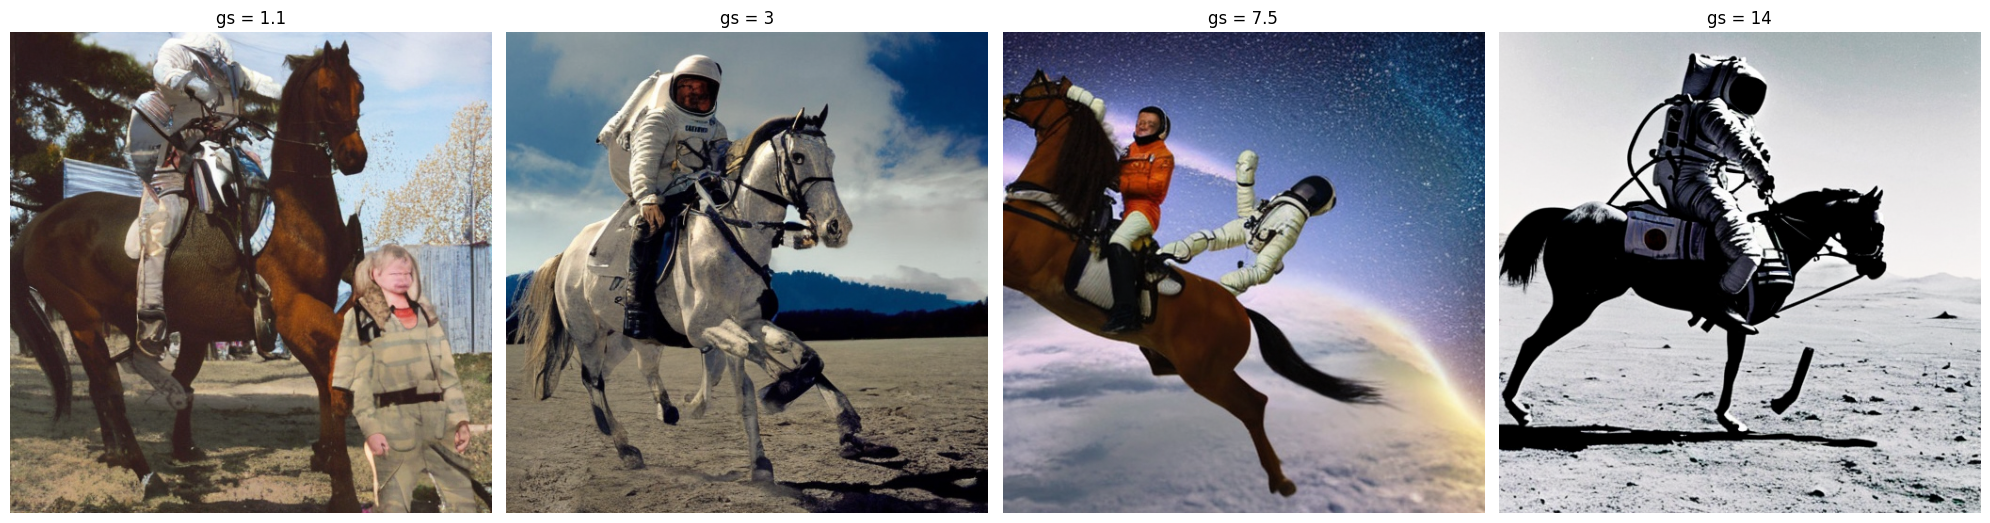

In [41]:
disp_imgs(imgs)